In [ ]:
import liana as li
import scanpy as sc
from anndata import AnnData
import pandas as pd
from liana.mt import rank_aggregate
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
from pycirclize import Circos

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# loading original anndata
pvat_cell_atlas_data_final = sc.read_h5ad('../data/PVAT_BAT_SCPAnnotated.h5ad')
pvat_cell_atlas_data_final

AnnData object with n_obs × n_vars = 58090 × 14522
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'scDblFinder_score', 'scDblFinder_class', 'Sample', 'tissue', '_scvi_batch', '_scvi_labels', 'leiden0.1', 'leiden0.2', 'leiden0.3', 'leiden0.5', 'leiden0.8', 'leiden1.0', 'leiden1.2', 'leiden1.5', 'leiden', 'female_epithelial', 'adipocyte', 'male_epithelial', 'dendritic_cell', 'macrophage', 'ASPC', 'monocyte', 'endothelial', 'SMC', 'nk_cell', 'LEC', 'pericyte', 't_cell', 'b_cell', 'mast_cell', 'neutrophil', 'mesothelium', 'endometrium', 'CD4+ T-cells', 'Adipocytes', 'Macrophages', 'Fibroblasts/Preadipocytes', 'Fibroblasts/Chondrocytes', 'Endothelial cells', 'B-cells', 'Skeletal m

In [3]:
pvat_cell_atlas_data_final.obs['celltype'].unique().tolist()

['Adipocytes',
 'SMCs & Pericytes',
 'ASPC',
 'Adipocytes_2',
 'Endothelial cells',
 'Immune cells',
 'Mesothelium',
 'Neuronal-like cells']

In [4]:
# Normalize the gene expression data to a total count of 10,000 per cell, then apply a log transformation to stabilize variance across cells.
sc.pp.normalize_total(pvat_cell_atlas_data_final, target_sum=1e4)
sc.pp.log1p(pvat_cell_atlas_data_final)

In [5]:
pvat_cell_atlas_data_final.obs['organ__ontology_label'].unique().tolist()

['adipose tissue|perivascular space|thoracic aorta', 'brown adipose tissue']

In [6]:
pvat_metadata = pvat_cell_atlas_data_final.obs
pvat_metadata = pvat_metadata[(pvat_metadata.loc[:,'organ__ontology_label'] == 'adipose tissue|perivascular space|thoracic aorta')]
pvat_metadata.head()

,sample_id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,...,cell_type__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,organism_age,organism_age__unit,organism_age__unit_label,library_preparation_protocol,library_preparation_protocol__ontology_label
AAACCCAAGACAACTA-1-0,PPG1,1006,6.914731,1795.0,7.493317,27.298050,176.0,5.176150,9.805014,14.0,...,fat cell,PATO_0000461,normal,UBERON_0001013|UBERON_0014930|UBERON_0001515,adipose tissue|perivascular space|thoracic aorta,16,UO_0000034,week,EFO_0009922,10x 3' v3
AAACCCAAGGATTCAA-1-0,PPG1,2566,7.850493,7381.0,8.906800,26.703699,230.0,5.442418,3.116109,24.0,...,fat cell,PATO_0000461,normal,UBERON_0001013|UBERON_0014930|UBERON_0001515,adipose tissue|perivascular space|thoracic aorta,16,UO_0000034,week,EFO_0009922,10x 3' v3
AAACCCAAGTCCCTAA-1-0,PPG1,1730,7.456455,4428.0,8.395929,29.268293,234.0,5.459586,5.284553,27.0,...,fat cell,PATO_0000461,normal,UBERON_0001013|UBERON_0014930|UBERON_0001515,adipose tissue|perivascular space|thoracic aorta,16,UO_0000034,week,EFO_0009922,10x 3' v3
AAACCCACAACAGAGC-1-0,PPG1,1506,7.317876,3523.0,8.167352,31.762702,273.0,5.613128,7.749078,23.0,...,fat cell,PATO_0000461,normal,UBERON_0001013|UBERON_0014930|UBERON_0001515,adipose tissue|perivascular space|thoracic aorta,16,UO_0000034,week,EFO_0009922,10x 3' v3
AAACCCACAATGCTCA-1-0,PPG1,1767,7.477604,4167.0,8.335192,25.557955,196.0,5.283204,4.703624,16.0,...,fat cell,PATO_0000461,normal,UBERON_0001013|UBERON_0014930|UBERON_0001515,adipose tissue|perivascular space|thoracic aorta,16,UO_0000034,week,EFO_0009922,10x 3' v3


In [7]:
# List available methods in lliana framework
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


In [8]:
singlecellsignalr.describe()

SingleCellSignalR uses `lrscore` and `None` as measures of expression strength and interaction specificity, respectively


### PVAT DATA

In [9]:
# Filtering pvat anndata from the combined anndata
pvat_cell_index = pvat_cell_atlas_data_final.obs.loc[:,'organ__ontology_label'] == 'adipose tissue|perivascular space|thoracic aorta'
pvat_adata = pvat_cell_atlas_data_final[pvat_cell_index,:]
pvat_adata

View of AnnData object with n_obs × n_vars = 29703 × 14522
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'scDblFinder_score', 'scDblFinder_class', 'Sample', 'tissue', '_scvi_batch', '_scvi_labels', 'leiden0.1', 'leiden0.2', 'leiden0.3', 'leiden0.5', 'leiden0.8', 'leiden1.0', 'leiden1.2', 'leiden1.5', 'leiden', 'female_epithelial', 'adipocyte', 'male_epithelial', 'dendritic_cell', 'macrophage', 'ASPC', 'monocyte', 'endothelial', 'SMC', 'nk_cell', 'LEC', 'pericyte', 't_cell', 'b_cell', 'mast_cell', 'neutrophil', 'mesothelium', 'endometrium', 'CD4+ T-cells', 'Adipocytes', 'Macrophages', 'Fibroblasts/Preadipocytes', 'Fibroblasts/Chondrocytes', 'Endothelial cells', 'B-cells', 'Sk

In [11]:
pvat_adata.raw = pvat_adata
pvat_adata.raw.X

<29703x14522 sparse matrix of type '<class 'numpy.float64'>'
	with 37014300 stored elements in Compressed Sparse Row format>

In [13]:
# Run CellPhoneDB analysis on PVAT data
cellphonedb(pvat_adata, groupby='celltype', expr_prop=0.1, resource_name='mouseconsensus', verbose=True, key_added='cellphonedb_res')

Using `.raw`!
/Users/pandavis/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
['NEWGENE_1306714', 'NEWGENE_1310561', 'NEWGENE_1310139', 'NEWGENE_621351', 'Y_RNA-4', 'NEWGENE_1308612', 'RNaseP_nuc-10', 'NEWGENE_1582771', 'Metazoa_SRP-10', 'Y_RNA-10', 'RNase_MRP', '5S_rRNA-89', '5S_rRNA-97', '5S_rRNA-100', '5S_rRNA-117', '5S_rRNA-118', 'NEWGENE_1306267', '5S_rRNA-132', 'NEWGENE_1308196', 'NEWGENE_620180', '5S_rRNA-165', '5S_rRNA-188', '5S_rRNA-193', 'NEWGENE_6497122', 'Metazoa_SRP-24', 'NEWGENE_1359268', 'NEWGENE_1304700', 'NEWGENE_1308171', '5S_rRNA-256', '5S_rRNA-259', '5S_rRNA-264', '5S_rRNA-273'] contain `_`. Consider replacing those!
Using resource `mouseconsensus`.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 29703 samples and 14522 features


100%|█████████████████████████████████████████| 1000/1000 [00:13<00:00, 74.22it/s]


In [ ]:
#cellphonedb results
ligand_receptor_pvat = pvat_adata.uns['cellphonedb_res']
ligand_receptor_pvat.head()

In [ ]:
ligand_receptor_pvat.to_csv("pvat_cci_using_cellphonedb.csv")

In [77]:
ligand_receptor_string = (ligand_receptor_pvat.loc[:,'ligand_complex'].str.contains('Col')) & (ligand_receptor_pvat.loc[:,'receptor_complex'].str.contains('Itg'))
cell_source_string = ligand_receptor_pvat.loc[:,'source'] == 'ASPC'
cell_target_string = ligand_receptor_pvat.loc[:,'target'] == 'Adipocytes'
cell_pvals = ligand_receptor_pvat.loc[:,'cellphone_pvals'] <= 0.05

ligand_receptor_pvat[ligand_receptor_string & cell_source_string & cell_target_string & cell_pvals]

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
1772,Col4a1,Col4a1,2.221201,0.762097,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,1.452416,0.0
1818,Col3a1,Col3a1,1.803552,0.717742,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,1.243591,0.0
1812,Col5a3,Col5a3,1.373749,0.559140,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,1.028690,0.0
1814,Col5a2,Col5a2,1.244476,0.567204,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,0.964053,0.0
1784,Col6a2,Col6a2,1.242934,0.560484,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,0.963282,0.0
1816,Col5a1,Col5a1,0.774780,0.401882,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,0.729205,0.0
1778,Col4a2,Col4a2,0.773719,0.373656,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,0.728675,0.0
1768,Col6a6,Col6a6,0.691360,0.325269,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,0.687495,0.0
1770,Col1a1,Col1a1,0.533353,0.263441,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,0.608492,0.0
1790,Col4a4,Col4a4,0.492703,0.270161,Itgb1,Itga1_Itgb1,0.683631,0.363956,ASPC,Adipocytes,0.588167,0.0


In [14]:
# Run cCellchat analysis on PVAT data
cellchat(pvat_adata, groupby='celltype', expr_prop=0.1, resource_name='mouseconsensus', verbose=True, key_added='cellchat_res')

In [20]:
ligand_receptor_pvat.to_csv("pvat_cci_using_cellchat.csv")

### 

In [78]:
#cellchat results
ligand_receptor_pvat = pvat_adata.uns['cellchat_res']
ligand_receptor_pvat.head()

,ligand,ligand_complex,ligand_props,ligand_trimean,mat_max,receptor,receptor_complex,receptor_props,receptor_trimean,source,target,lr_probs,cellchat_pvals
2424,App,App,0.847328,0.310844,7.355702,Lrp6,Lrp6,0.978139,0.537985,Mesothelium,Adipocytes,0.250632,0.0
6408,App,App,0.847328,0.310844,7.355702,Lrp6,Lrp6,0.919949,0.495399,Mesothelium,Immune cells,0.235464,0.0
1839,App,App,0.763441,0.278940,7.355702,Lrp6,Lrp6,0.978139,0.537985,ASPC,Adipocytes,0.230846,0.0
4939,App,App,0.847328,0.310844,7.355702,Lrp6,Lrp6,0.878685,0.478230,Mesothelium,Endothelial cells,0.229174,0.0
10867,App,App,0.847328,0.310844,7.355702,Lrp6,Lrp6,0.872581,0.472723,Mesothelium,SMCs & Pericytes,0.227134,0.0


In [79]:
ligand_receptor_string = (ligand_receptor_pvat.loc[:,'ligand_complex'].str.contains('Col')) & (ligand_receptor_pvat.loc[:,'receptor_complex'].str.contains('Itg'))
cell_source_string = ligand_receptor_pvat.loc[:,'source'] == 'ASPC'
cell_target_string = ligand_receptor_pvat.loc[:,'target'] == 'Adipocytes'
cell_pvals = ligand_receptor_pvat.loc[:,'cellchat_pvals'] <= 0.05

ligand_receptor_pvat[ligand_receptor_string & cell_source_string & cell_target_string & cell_pvals]

,ligand,ligand_complex,ligand_props,ligand_trimean,mat_max,receptor,receptor_complex,receptor_props,receptor_trimean,source,target,lr_probs,cellchat_pvals
1772,Col4a1,Col4a1,0.762097,0.331430,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.035309,0.0
1818,Col3a1,Col3a1,0.717742,0.232539,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.025037,0.0
1812,Col5a3,Col5a3,0.559140,0.193216,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.020892,0.0
1814,Col5a2,Col5a2,0.567204,0.174188,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.018873,0.0
1784,Col6a2,Col6a2,0.560484,0.172446,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.018688,0.0
1778,Col4a2,Col4a2,0.373656,0.060079,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.006591,0.0
1816,Col5a1,Col5a1,0.401882,0.059294,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.006506,0.0
1768,Col6a6,Col6a6,0.325269,0.053821,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.005909,0.0
1770,Col1a1,Col1a1,0.263441,0.043814,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.004815,0.0
1790,Col4a4,Col4a4,0.270161,0.041502,7.355702,Itgb1,Itga1_Itgb1,0.363956,0.055217,ASPC,Adipocytes,0.004562,0.0


### BAT DATA

In [27]:
bat_cell_index = pvat_cell_atlas_data_final.obs.loc[:,'organ__ontology_label'] == 'brown adipose tissue'
bat_adata = pvat_cell_atlas_data_final[bat_cell_index,:]
bat_adata

View of AnnData object with n_obs × n_vars = 28387 × 14522
    obs: 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'scDblFinder_score', 'scDblFinder_class', 'Sample', 'tissue', '_scvi_batch', '_scvi_labels', 'leiden0.1', 'leiden0.2', 'leiden0.3', 'leiden0.5', 'leiden0.8', 'leiden1.0', 'leiden1.2', 'leiden1.5', 'leiden', 'female_epithelial', 'adipocyte', 'male_epithelial', 'dendritic_cell', 'macrophage', 'ASPC', 'monocyte', 'endothelial', 'SMC', 'nk_cell', 'LEC', 'pericyte', 't_cell', 'b_cell', 'mast_cell', 'neutrophil', 'mesothelium', 'endometrium', 'CD4+ T-cells', 'Adipocytes', 'Macrophages', 'Fibroblasts/Preadipocytes', 'Fibroblasts/Chondrocytes', 'Endothelial cells', 'B-cells', 'Sk

In [28]:
bat_adata.raw = bat_adata
bat_adata.raw.X

<28387x14522 sparse matrix of type '<class 'numpy.float64'>'
	with 41882973 stored elements in Compressed Sparse Row format>

In [30]:
cellphonedb(bat_adata, groupby='celltype', expr_prop=0.1, resource_name='mouseconsensus', verbose=True, key_added='cellphonedb_res')

Using `.raw`!
/Users/pandavis/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
The following cell identities were excluded: Mesothelium
['NEWGENE_1306714', 'NEWGENE_1310561', 'NEWGENE_1310139', 'NEWGENE_621351', 'Y_RNA-4', 'NEWGENE_1308612', 'RNaseP_nuc-10', 'NEWGENE_1582771', 'Metazoa_SRP-10', 'Y_RNA-10', 'RNase_MRP', '5S_rRNA-89', '5S_rRNA-97', '5S_rRNA-100', '5S_rRNA-117', '5S_rRNA-118', 'NEWGENE_1306267', '5S_rRNA-132', 'NEWGENE_1308196', 'NEWGENE_620180', '5S_rRNA-165', '5S_rRNA-188', '5S_rRNA-193', 'NEWGENE_6497122', 'Metazoa_SRP-24', 'NEWGENE_1359268', 'NEWGENE_1304700', 'NEWGENE_1308171', '5S_rRNA-256', '5S_rRNA-259', '5S_rRNA-264', '5S_rRNA-273'] contain `_`. Consider replacing those!
Using resource `mouseconsensus`.
0.34 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 28386 samples and 14522 features


100%|██████████████████████| 1000/1000 [00:07<00:00, 137.49it/s]


In [31]:
ligand_receptor_bat = bat_adata.uns['cellphonedb_res']
ligand_receptor_bat.head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
1404,App,App,2.046788,0.872727,Lrp6,Lrp6,3.951463,0.99623,ASPC,Adipocytes,2.999125,0.0
2240,App,App,1.987442,0.836864,Lrp6,Lrp6,3.951463,0.99623,SMCs & Pericytes,Adipocytes,2.969452,0.0
2068,App,App,1.829086,0.813433,Lrp6,Lrp6,3.951463,0.99623,Neuronal-like cells,Adipocytes,2.890274,0.0
1665,App,App,1.791849,0.753086,Lrp6,Lrp6,3.951463,0.99623,Adipocytes_2,Adipocytes,2.871656,0.0
1789,App,App,1.680009,0.779623,Lrp6,Lrp6,3.951463,0.99623,Endothelial cells,Adipocytes,2.815736,0.0


In [32]:
ligand_receptor_string = (ligand_receptor_bat.loc[:,'ligand_complex'].str.contains('Col')) & (ligand_receptor_bat.loc[:,'receptor_complex'].str.contains('Itg'))
cell_source_string = ligand_receptor_bat.loc[:,'source'] == 'Neuronal-like cells'
cell_target_string = ligand_receptor_bat.loc[:,'target'] == 'ASPC'
cell_pvals = ligand_receptor_bat.loc[:,'cellphone_pvals'] <= 0.05

ligand_receptor_bat[ligand_receptor_string & cell_source_string & cell_target_string & cell_pvals]

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
903,Col4a1,Col4a1,2.261086,0.895522,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,1.565039,0.001
939,Col5a2,Col5a2,1.223640,0.604478,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,1.046316,0.000
937,Col5a3,Col5a3,1.015050,0.544776,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,0.942021,0.000
943,Col3a1,Col3a1,0.915259,0.514925,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,0.892126,0.000
907,Col4a2,Col4a2,0.799910,0.432836,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,0.834451,0.001
924,Col16a1,Col16a1,0.535047,0.320896,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,0.702019,0.000
941,Col5a1,Col5a1,0.511533,0.320896,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,0.690263,0.000
927,Col27a1,Col27a1,0.407532,0.261194,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,0.638262,0.000
1005,Col4a2,Col4a2,0.799910,0.432836,Itgb5,Itgb5,0.434559,0.267532,Neuronal-like cells,ASPC,0.617234,0.000
945,Col18a1,Col18a1,0.304808,0.186567,Itga1,Itga1_Itgb1,0.868992,0.500000,Neuronal-like cells,ASPC,0.586900,0.003


## Chord Diagrams

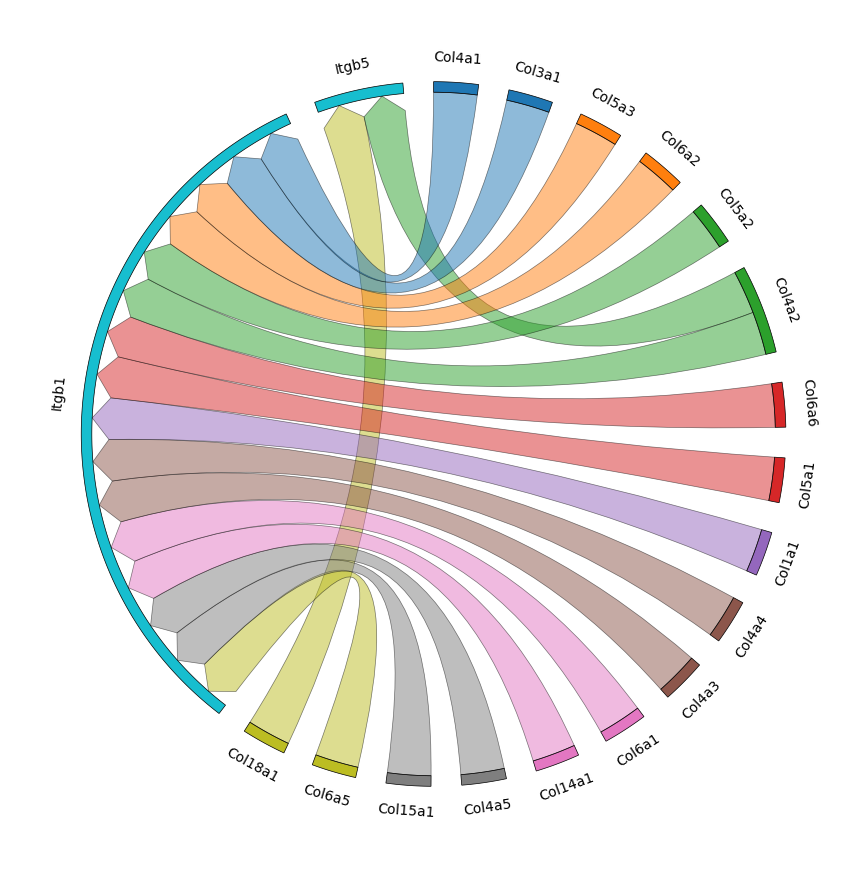

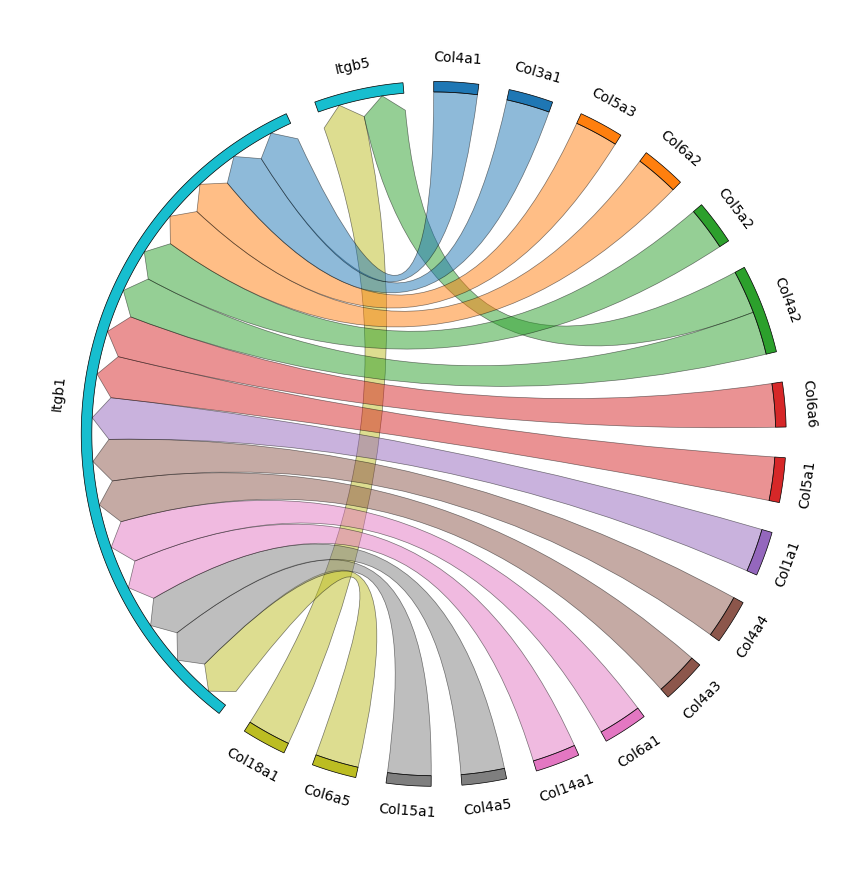

In [41]:
#cell_type_to_filter = ['Adipocytes', 'Endothelial_Cells', 'Fibroblasts_Bmper+', 'Pericytes', 'T_Cells', 'Myeloid Cells']#, 'Neuronal_Cells', 'Dendritic_Cells']
interaction_df = ligand_receptor_df[ligand_receptor_string & cell_source_string & cell_target_string & cellphone_pvals][['ligand','receptor']]
#interaction_df = interaction_df[interaction_df['source'] == 'Adipocytes']

#interaction_df = interaction_df[interaction_df['source'].isin(cell_type_to_filter) & interaction_df['target'].isin(cell_type_to_filter)]
all_cells = pd.unique(interaction_df[['ligand', 'receptor']].values.ravel('K'))

interaction_matrix = pd.DataFrame(0, index=all_cells, columns=all_cells)

for index, row in interaction_df.iterrows():
    interaction_matrix.at[row['ligand'], row['receptor']] = 1

circos = Circos.initialize_from_matrix(
    interaction_matrix,
    space=5,
    cmap="tab10",
    label_kws=dict(size=10),
    link_kws=dict(ec="black", lw=0.5, direction=1),
)

circos.plotfig()